In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi']
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['axes.unicode_minus']=False
df = pd.read_excel('../Data/客流量data.xlsx').sort_values(by=['月份','店名'])
data = df.drop(['ERPID','SAPID','战区'],axis=1)
data['月份'] = pd.to_datetime(data['月份'])
data.replace('-', pd.NA, inplace=True)
cols_to_drop = ['同期有效记录天数', '同期店前客流', '同期进店客流', '同期线下成交', '同期线上成交']
data.drop(columns=cols_to_drop, inplace=True)

## 1. 特征处理

In [2]:
# 1. 创建新的特征，标准化客流量和成交量
data['本期日均店前客流量'] = data['本期店前客流'] / data['本期有效记录天数']
data['本期日均进店客流'] = data['本期进店客流'] / data['本期有效记录天数']
data['本期日均线下成交'] = data['本期线下成交'] / data['本期有效记录天数']
data['本期日均线上成交'] = data['本期线上成交'] / data['本期有效记录天数']

# 2. 创建转化率特征
data['本期进店转化率'] = data['本期进店客流'] / data['本期店前客流']
data['本期线下成交转化率'] = data['本期线下成交'] / data['本期进店客流']
data['本期线上成交转化率'] = data['本期线上成交'] / data['本期进店客流']

# 3. 删除现在不需要的列
data.drop(columns=['本期有效记录天数'], inplace=True)

display(data.head())

,月份,店名,本期店前客流,本期进店客流,本期线下成交,本期线上成交,本期日均店前客流量,本期日均进店客流,本期日均线下成交,本期日均线上成交,本期进店转化率,本期线下成交转化率,本期线上成交转化率
13648,2023-01-01,上海公司中山北路店,54814,4104,1409,3678,1768.193548,132.387097,45.451613,118.645161,0.074871,0.343324,0.896199
8169,2023-01-01,上海公司五莲路店,87001,7781,2412,4502,2806.483871,251.000000,77.806452,145.225806,0.089436,0.309986,0.578589
24895,2023-01-01,上海公司南山路店,111131,3074,880,726,3832.103448,106.000000,30.344828,25.034483,0.027661,0.286272,0.236174
2492,2023-01-01,上海公司大连路店,593,181,124,211,296.500000,90.500000,62.000000,105.500000,0.305228,0.685083,1.165746
14213,2023-01-01,上海公司宜川店,250838,6558,1710,584,8361.266667,218.600000,57.000000,19.466667,0.026144,0.260750,0.089052


## 2.模型拟合

### 2.1 多项式拟合

总 MAE: 24.91
总 Accuracy: 83.84%


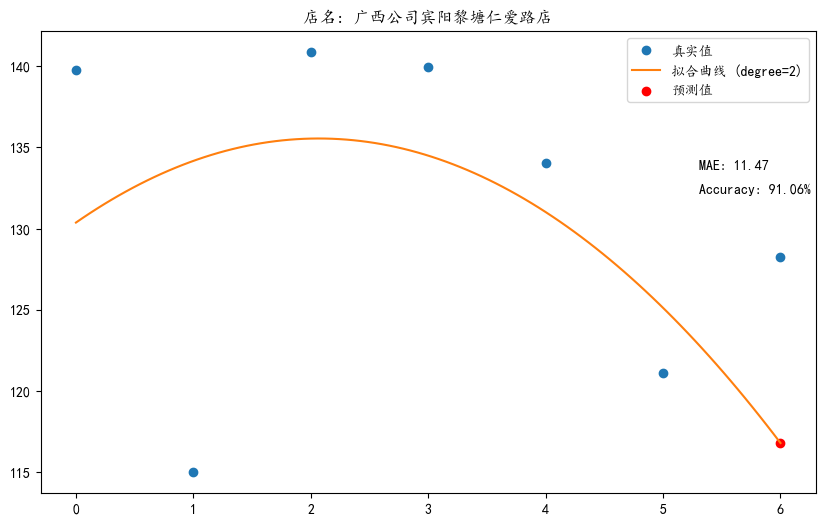

In [13]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 定义多项式的度数，例如2
degree = 2
polynomial_features = PolynomialFeatures(degree=degree)

# 存储所有门店的误差和精准度
all_mae = []
all_accuracies = []

stores = data['店名'].unique()
valid_stores = [store for store in stores if len(data[data['店名'] == store]) >= 7]

for store in valid_stores:
    sub_data = data[data['店名'] == store].sort_values(by='月份')
    time_series = sub_data['本期日均进店客流'].values
    months = np.array(range(len(time_series)))
    months_poly = polynomial_features.fit_transform(months.reshape(-1, 1))

    train_x, test_x = months_poly[:-1], months_poly[-1:]
    train_y, test_y = time_series[:-1], time_series[-1:]

    model = LinearRegression().fit(train_x, train_y)
    predictions = model.predict(test_x)
    
    mae = np.abs(predictions[0] - test_y[0])
    accuracy_percentage = (1 - (mae / test_y[0])) * 100
    
    all_mae.append(mae)
    all_accuracies.append(accuracy_percentage)

# 计算整体误差和精准度
overall_mae = np.mean(all_mae)
overall_accuracy = np.mean(all_accuracies)

print(f"总 MAE: {overall_mae:.2f}")
print(f"总 Accuracy: {overall_accuracy:.2f}%")

# 随机选择一个门店进行绘图
random_store = np.random.choice(valid_stores)
sub_data = data[data['店名'] == random_store].sort_values(by='月份')
time_series = sub_data['本期日均进店客流'].values
months = np.array(range(len(time_series)))
months_poly = polynomial_features.transform(months.reshape(-1, 1))

train_x, test_x = months_poly[:-1], months_poly[-1:]
train_y, test_y = time_series[:-1], time_series[-1:]

model = LinearRegression().fit(train_x, train_y)
predictions = model.predict(test_x)

mae = np.abs(predictions[0] - test_y[0])
accuracy_percentage = (1 - (mae / test_y[0])) * 100

x_range = np.linspace(min(months), max(months), 100)
y_range_poly = polynomial_features.transform(x_range.reshape(-1, 1))
y_range = model.predict(y_range_poly)

plt.figure(figsize=(10, 6))
plt.plot(months, time_series, 'o', label='真实值')
plt.plot(x_range, y_range, label=f'拟合曲线 (degree={degree})')
plt.scatter(months[-1], predictions, color='red', label='预测值')
plt.title(f'店名: {random_store}')

plt.annotate(f'MAE: {mae:.2f}', xy=(0.85, 0.7), xycoords='axes fraction')
plt.annotate(f'Accuracy: {accuracy_percentage:.2f}%', xy=(0.85, 0.65), xycoords='axes fraction')

plt.legend()
plt.show()

### 2.2 机器学习方法

[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3942, number of used features: 6
[LightGBM] [Info] Start training from score 164.729027
总 MAE: 17.54
总 Accuracy: 89.47%


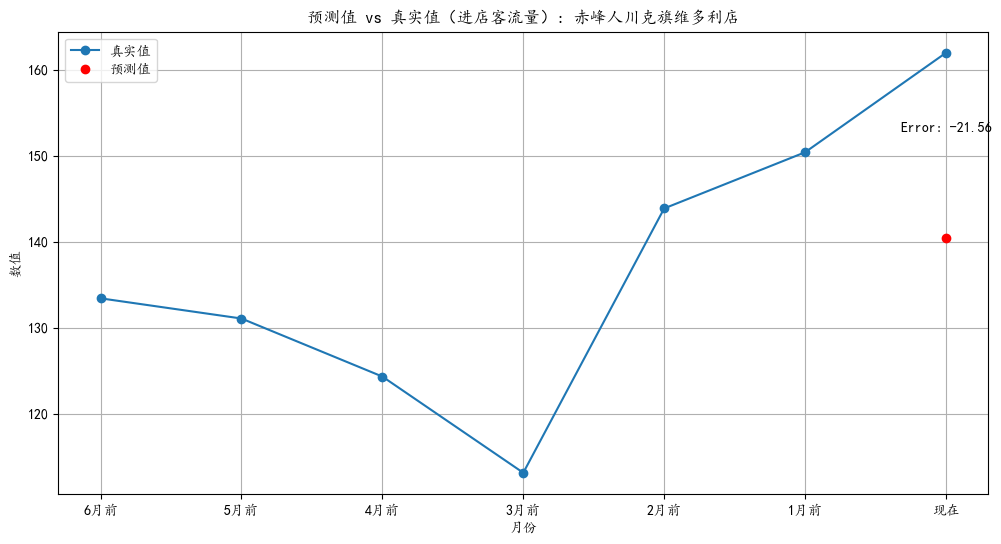

In [45]:
# 计算月份的唯一数量
unique_months_count = data['月份'].nunique()

# 创建滞后特征，考虑到我们不可能为所有月份创建滞后特征，这里设置最多创建unique_months_count - 1个滞后特征
max_lag = min(unique_months_count - 1, 12)  

# 为 '本期日均进店客流' 创建滞后特征
for lag in range(1, max_lag + 1):
    lag_column = f"lag_{lag}_本期日均进店客流"
    data[lag_column] = data.groupby('店名')['本期日均进店客流'].shift(lag)


# 只保留目标变量和其滞后特征
columns_to_keep = ['月份', '店名', '本期日均进店客流']
for lag in range(1, max_lag + 1):
    columns_to_keep.append(f"lag_{lag}_本期日均进店客流")

filtered_data = data[columns_to_keep].dropna(axis=0)

# 使用 '月份' 和 '店名' 作为双重索引
filtered_data.set_index(['月份', '店名'], inplace=True)

# 定义特征和目标变量
X = filtered_data.drop(columns=['本期日均进店客流'])
y = filtered_data['本期日均进店客流']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 使用LGBM进行训练
model = lgb.LGBMRegressor(learning_rate=0.05, max_depth= 1, n_estimators=200,force_col_wise=True)
model.fit(X_train, y_train)

# 预测
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mae = mean_absolute_error(y_test, y_pred)
print(f"总 MAE: {mae:.2f}")
print(f"总 Accuracy: {(1 - (mae / y_test.mean())) * 100:.2f}%")
# 随机选择一个店铺
random_shop = np.random.choice(filtered_data.index.get_level_values('店名').unique())
    
# 获取特定店铺的数据
shop_data = filtered_data.xs(key=random_shop, level='店名', axis=0)
y_shop_true = shop_data['本期日均进店客流'].values
X_shop = shop_data.drop(columns=['本期日均进店客流'])

# 使用模型进行预测
y_shop_pred = model.predict(X_shop)

# 绘制折线图
plt.figure(figsize=(12, 6))
months = [f'{i}月前' for i in range(max_lag, 0, -1)] + ['现在']
plt.plot(months, X_shop.iloc[0, ::-1].values.tolist() + [y_shop_true[0]], label='真实值', marker='o')
plt.plot(months[-1], y_shop_pred[0], 'ro', label='预测值')

# 标注预测值和真实值的差距
plt.annotate(f"Error: {y_shop_pred[0] - y_shop_true[0]:.2f}", 
             (months[-1], (y_shop_true[0] + y_shop_pred[0]) / 2),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')

plt.title(f"预测值 vs 真实值（进店客流量）: {random_shop}")
plt.xlabel('月份')
plt.ylabel('数值')
plt.legend()
plt.grid(True)
plt.show()